# SIR Epidemiology model: Outbreak on Tristan de Cunha

This example shows how the [SIRModel](http://pints.readthedocs.io/en/latest/toy/sir_model.html) can be used.

The SIR model describes a disease breaking out in a population split into a susceptible (S), infected (I), and recovered (R) part (see [wikipedia](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model)).

The formulation shown here was used by [Toni et al.](http://rsif.royalsocietypublishing.org/content/6/31/187.short), in a paper in which they also give real data of a common-cold outbreak on the isle of Tristan de Cunha. In this formulation, the susceptible population is unknown, the we can observe the infected and recovered population.

The model has three parameters: infection rate ``gamma``, recovery rate ``v``, and the initial susceptible population ``S0``.



Parameters:
[0.026, 0.285, 38]


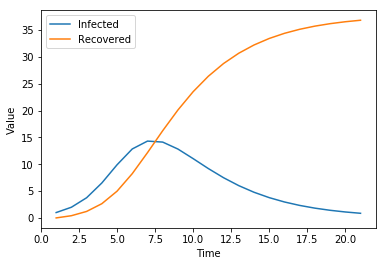

In [17]:
import pints
import pints.toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create a model
model = pints.toy.SIRModel()

# Run a simulation
parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(parameters, times)

print('Parameters:')
print(parameters)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values)
plt.legend(['Infected', 'Recovered'])
plt.show()

We can have a look at the real data too:

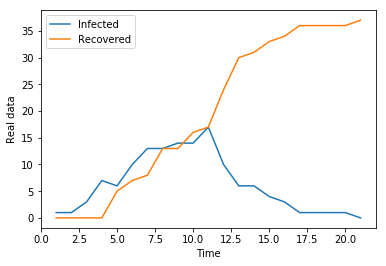

In [23]:
real_values = model.suggested_values()

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Real data')
plt.plot(times, real_values)
plt.legend(['Infected', 'Recovered'])
plt.show()

Next, we set up a problem. Because this model has multiple outputs (2), we use a [MultiOutputProblem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#multi-output-problem).

In [24]:
problem = pints.MultiOutputProblem(model, times, real_values)
score = pints.SumOfSquaresError(problem)

We can now use MCMC to have a guess at the parameters! We'll try to infer two noise parameters `sigma-I` and `sigma-R` at the same time (although notice that in this case we actually have perfect information!).

In [21]:
# Log likelihood
loglikelihood = pints.UnknownNoiseLogLikelihood(problem)

# Starting points
x0 = [
    [0.001, 0.20, 52, 5, 5],
    [0.05, 0.34, 34, 5, 5],
    [0.02, 0.18, 20, 5, 5],
]

# Create MCMC routine
mcmc = pints.MCMCSampling(loglikelihood, 3, x0)
mcmc.set_max_iterations(3000)
mcmc.set_log_to_screen(False)
chains = mcmc.run()

/home/michael/dev/pints/pints/_log_likelihoods.py:155: RuntimeWarning: invalid value encountered in log
  - np.sum(error**2, axis=0) / (2 * sigma**2))


We now have a quick look at the traces, to get an indication of how well the chains have converged:

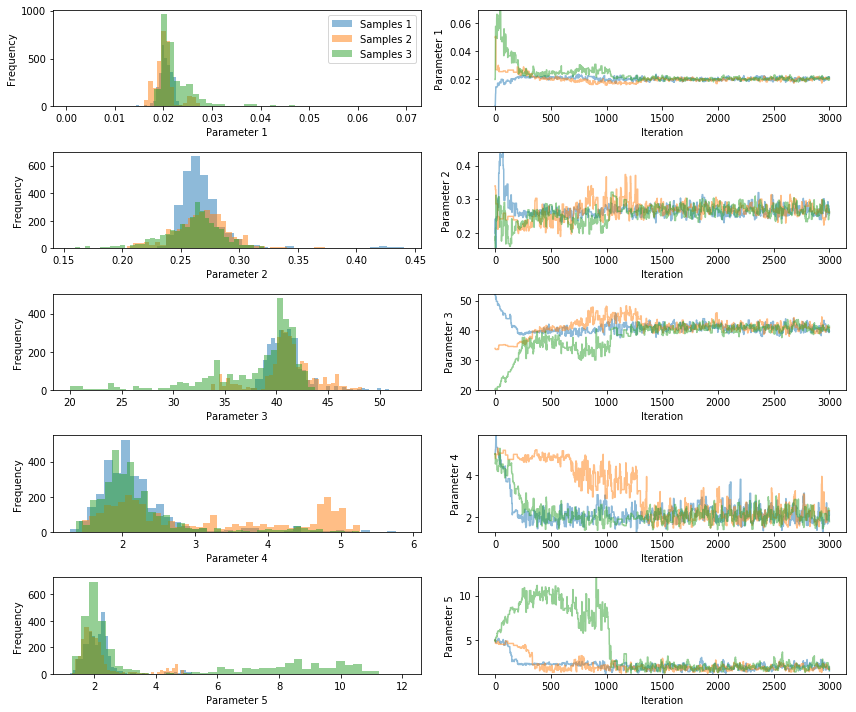

In [22]:
plt.figure()
pints.plot.trace(chains)
plt.show()

Finally, we compare some predictions based on the final samples to the real data:

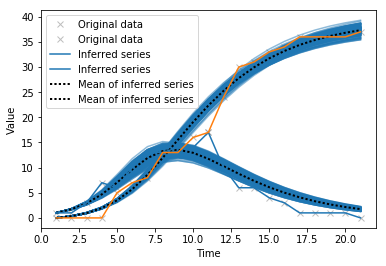

In [27]:
samples = chains[0, -1000:]

plt.figure()
ax = pints.plot.series(samples, problem)
plt.plot(times, real_values)
plt.show()